# Immigration Analysis
### Data Engineering Capstone Project

#### Project Summary
This project intends to prepare an analytical database for the study of immigration into the United States based on the I94 data. This incorporates the design of an ETL process which includes data modeling (i.e. a database schema) and data cleansing. The main focus of the analytical database will lie on:

* Mode of entrance (vehicle and visa type)
* Destination and origin of travel
* Date of entrance and duration of stay in the country


The project consists of the following steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [14]:
# Do all imports and installs here
import pandas as pd
import datetime

# We will be using PySpark, as will be justified later:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, expr, pandas_udf, year, month, dayofmonth, col, lit
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType, DateType, TimestampType

### Step 1: Scope the Project and Gather Data

#### Scope 
*Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>*

We intend to make a database model, i.e. design a database relationship model, and an ETL process. 
Our main tools will be `Pandas` for initial data exploration, and -- for the heavy weight lifting -- Spark (in particular `PySpark`). For data storage, we will use `Parquet` since this data format allows for fast and efficient querying.

#### Describe and Gather Data 
*Describe the data sets you're using. Where did it come from? What type of information is included?*

We will use US immigration data from the year 2016 which has been provided by the US National Tourism and Trade office through its website. This dataset includes data such as the place of immigration (border), the visa type, the date of arrival, the duration of stay, and many more.

## US immigration data from the year 2016 - Sample

In [2]:
df_pandas = pd.read_csv('immigration_data_sample.csv')
df_pandas.head(10)

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT
5,721257,1481650.0,2016.0,4.0,577.0,577.0,ATL,20552.0,1.0,GA,...,NaN,M,1965.0,10072016,M,NaN,DL,7.368526e+08,910,B2
6,1072780,2197173.0,2016.0,4.0,245.0,245.0,SFR,20556.0,1.0,CA,...,NaN,M,1968.0,10112016,F,NaN,CX,7.863122e+08,870,B2
7,112205,232708.0,2016.0,4.0,113.0,135.0,NYC,20546.0,1.0,NY,...,NaN,M,1983.0,06302016,F,NaN,BA,5.547449e+10,00117,WT
8,2577162,5227851.0,2016.0,4.0,131.0,131.0,CHI,20572.0,1.0,IL,...,NaN,M,1977.0,07262016,NaN,NaN,LX,5.941342e+10,00008,WT
9,10930,13213.0,2016.0,4.0,116.0,116.0,LOS,20545.0,1.0,CA,...,NaN,M,1981.0,06292016,NaN,NaN,AA,5.544979e+10,00109,WT


## Airport Codes

In [3]:
df_pandas = pd.read_csv('airport-codes_csv.csv')
df_pandas.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


## Demographics of US-Cities

In [4]:
# Strictly speaking, semicolon-separated data:
df_pandas = pd.read_csv('us-cities-demographics.csv', sep=';')
df_pandas.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


## Temperature Data

In [5]:
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_pandas = pd.read_csv(fname)
df_pandas.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


# Utilizing Spark

Since this is only a sample, we will try out Pandas with the monthly data of the whole dataset. As per the instructions, the raw immigration data is stored in the directory `../../data/18-83510-I94-Data-2016/` and is partitioned into monthly datasets as indicated by three-letter month codes, e.g. `i94_jan16_sub.sas7bdat`.

In [6]:
fname = '../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat'
df_pandas = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")

As expected, the processing takes too long, and we will have to utilize a genuine big data toolbox: *Spark*.

In [30]:
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

df = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat')

In order to work more efficiently with higher i/o-performance, we will convert the raw immigration data into **Parquet** format.

In [31]:
# Work with parquet
df.write.parquet("data_parquet/exploration")
df = spark.read.parquet("data_parquet/exploration")

In [52]:
df = spark.read.parquet("data_parquet/exploration")

For reference: Number of rows in the raw dataset.

In [33]:
df.count()

2847924

In [4]:
df.show(5)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|      admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+------------+-----+--------+
|  7.0|2016.0|   1.0| 101.0| 101.0|    BOS|20465.0|    1.0|     MA|   null|  20.0|    3.0|  1.0|    null|    null| null|      T|   null|   null|   null| 1996.0|     D/S|     M|  null|     LH|3.46608285E8|  424|      F1|
|  8.0|2016.0|   1.0| 101.0| 101.0|    BOS|20465.0|    1.0|     MA|   null|  20.0|    3.0|  1.0|    null|    null| null|

### Step 2: Explore and Assess the Data
#### Explore the Data 
*Identify data quality issues, like missing values, duplicate data, etc.*

In [11]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[cicid: double, i94yr: double, i94mon: double, i94cit: double, i94res: double, i94port: string, arrdate: double, i94mode: double, i94addr: string, depdate: double, i94bir: double, i94visa: double, count: double, dtadfile: string, visapost: string, occup: string, entdepa: string, entdepd: string, entdepu: string, matflag: string, biryear: double, dtaddto: string, gender: string, insnum: string, airline: string, admnum: double, fltno: string, visatype: string]>

#### Cleaning Steps
*Document steps necessary to clean the data*

We are looking for the following data:

In [61]:
df = spark.read.parquet("data_parquet/exploration")

In [62]:
# Number of entries before cleaning:
df.count()

2847924

In [67]:
df = df.filter("i94cit == i94res")\
        .filter("i94addr != ''")\
        .filter("i94mode is not null")\
        .filter("arrdate is not null")\
        .filter("depdate is not null")\
        .filter("i94visa is not null")\
        .filter("visatype != ''")


In [68]:
df.count()

1786071

In [69]:
df.dropDuplicates()

DataFrame[cicid: double, i94yr: double, i94mon: double, i94cit: double, i94res: double, i94port: string, arrdate: double, i94mode: double, i94addr: string, depdate: double, i94bir: double, i94visa: double, count: double, dtadfile: string, visapost: string, occup: string, entdepa: string, entdepd: string, entdepu: string, matflag: string, biryear: double, dtaddto: string, gender: string, insnum: string, airline: string, admnum: double, fltno: string, visatype: string]

In [70]:
df.count()

1786071

I.e., it seems like there weren't any duplicates left.

In [10]:
df = df.withColumn('immigration_id', expr('cast(cicid as int)')).withColumn('origin_id', expr('cast(i94cit as int)')).withColumn('visa_id', expr('cast(i94visa as int)')).withColumn('mode_id', expr('cast(i94mode as int)'))

In [11]:
get_timestamp_from_sas = udf(lambda sas: datetime.datetime(1960, 1, 1) + datetime.timedelta(days=int(sas)), TimestampType())

In [12]:
df = df.withColumn('arrival_date', get_timestamp_from_sas(df.arrdate)).withColumn('departure_date', get_timestamp_from_sas(df.depdate))

In [13]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[cicid: double, i94yr: double, i94mon: double, i94cit: double, i94res: double, i94port: string, arrdate: double, i94mode: double, i94addr: string, depdate: double, i94bir: double, i94visa: double, count: double, dtadfile: string, visapost: string, occup: string, entdepa: string, entdepd: string, entdepu: string, matflag: string, biryear: double, dtaddto: string, gender: string, insnum: string, airline: string, admnum: double, fltno: string, visatype: string, immigration_id: int, origin_id: int, visa_id: int, mode_id: int, arrival_date: timestamp, departure_date: timestamp]>

In [14]:
df = df.selectExpr('immigration_id', 'origin_id', 'i94addr as destination', 
                                                 'arrival_date', 'departure_date', 'dayofmonth(arrival_date) as day', 'month(arrival_date) as month', 'year(arrival_date) as year',
                                                 'mode_id', 'visa_id', 'visatype as visa_type_id')

In [15]:
df.head()

Row(immigration_id=9, origin_id=101, destination='CT', arrival_date=datetime.datetime(2016, 1, 16, 0, 0), departure_date=datetime.datetime(2016, 1, 27, 0, 0), day=16, month=1, year=2016, mode_id=1, visa_id=2, visa_type_id='B2')

Better use show() when using PySpark:

In [16]:
df.show()

+--------------+---------+-----------+-------------------+-------------------+---+-----+----+-------+-------+------------+
|immigration_id|origin_id|destination|       arrival_date|     departure_date|day|month|year|mode_id|visa_id|visa_type_id|
+--------------+---------+-----------+-------------------+-------------------+---+-----+----+-------+-------+------------+
|             9|      101|         CT|2016-01-16 00:00:00|2016-01-27 00:00:00| 16|    1|2016|      1|      2|          B2|
|            10|      101|         CT|2016-01-16 00:00:00|2016-02-15 00:00:00| 16|    1|2016|      1|      2|          B2|
|            11|      101|         CT|2016-01-16 00:00:00|2016-02-15 00:00:00| 16|    1|2016|      1|      2|          B2|
|            15|      101|         MA|2016-01-24 00:00:00|2016-03-11 00:00:00| 24|    1|2016|      1|      3|          F1|
|            20|      101|         IL|2016-01-20 00:00:00|2016-01-29 00:00:00| 20|    1|2016|      1|      2|          B2|
|            21|

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
*Map out the conceptual data model and explain why you chose that model*

#### 3.2 Mapping Out Data Pipelines
*List the steps necessary to pipeline the data into the chosen data model*

We select a star schema with a fact table in the middle, and four supplemental dimensional tables. The fact table will provide us with sufficiently fast OLAP performance while the much smaller dimensional tables contain additional information.

The ETL-pipeline will not be too complicated, as the immigration dataset already contains all the information required for the fact table. As a result, no JOIN-operations are required, and the pipeline mostly consists of ignoring certain columns.

<img src='images/ER_diagram.png'>

## Step 4: Run Pipelines to Model the Data 
## 4.1 Create the data model
*Build the data pipelines to create the data model.*

## 4.1.1 Fact Table

As already mentioned, the ETL pipeline for the fact table is rather simple to realize, i.e. JOINS are not needed.

In [79]:
def load_data(file):
    """
    Description: Load the data
    Arguments:   file: Filename of sas7bdat-file
    Returns:     None
    """
    file = '../../data/18-83510-I94-Data-2016/{}'.format(file)
    df = spark.read.format('com.github.saurfang.sas.spark').load(file)
    return df

In [71]:
def clean_data(df):
    """
    Description: Clean the data
    Arguments:   df: (Spark-)dataframe
    Returns:     Processed (Spark-)dataframe
    """
    df = df.filter("i94cit == i94res")\
        .filter("i94addr != ''")\
        .filter("i94mode is not null")\
        .filter("arrdate is not null")\
        .filter("depdate is not null")\
        .filter("i94visa is not null")\
        .filter("visatype != ''")
    return df.dropDuplicates()

In [72]:
def get_ids_columns(df):
    """
    Description: ds
    Arguments: (Spark-)dataframe
    Returns:   Processed (Spark-)dataframe
    """
    return df.withColumn('immigration_id', expr('cast(cicid as int)')).withColumn('origin_id', expr('cast(i94cit as int)')).withColumn('visa_id', expr('cast(i94visa as int)')).withColumn('mode_id', expr('cast(i94mode as int)'))


In [73]:
get_timestamp_from_sas = udf(lambda sas: datetime.datetime(1960, 1, 1) + datetime.timedelta(days=int(sas)), TimestampType())

In [74]:
def get_column_dates_from_sas_to_timestamp(df):
    """
    Description: asd
    Arguments:   df: (Spark-)dataframe
    Returns:     df: Processed (Spark-)dataframe
    """
    return df.withColumn('arrival_date', get_timestamp_from_sas(df.arrdate)).withColumn('departure_date', get_timestamp_from_sas(df.depdate))

In [75]:
def select_columns(df):
    """
    Description: asd
    Arguments:   df: (Spark-)dataframe
    Returns:     df: Processed (Spark-)dataframe
    """
    return df.selectExpr('immigration_id', 'origin_id', 'i94addr as destination', 'arrival_date', 'month(arrival_date) as arrival_month', 'departure_date', 'mode_id', 'visa_id', 'visatype as visa_type_id')

In [97]:
def etl_pipeline(batch):
    """
    Description: The ETL-Pipeline. Processes a batch of sas-files.
    Arguments:   batch: List of parquet-filenames
    Returns:     None
    """
    for num, name in enumerate(batch, start=1):
        df = load_data(name)
        df = clean_data(df)
        df = get_ids_columns(df)
        df = get_column_dates_from_sas_to_timestamp(df)
        df = select_columns(df)

        #df.write.partitionBy('visa_type_id').parquet('data_parquet/{}/'.format(num), mode='overwrite')
        df.write.partitionBy('arrival_month','visa_type_id').parquet('data_parquet/'.format(num), mode='append')

        print("Processed file {}: {}".format(num, name))

In [96]:
# A small batch for debugging purposes
batch = [
    'i94_jan16_sub.sas7bdat',
    'i94_feb16_sub.sas7bdat',
    'i94_mar16_sub.sas7bdat'
]

In [141]:
# We compile the file batch manually, as there are only twelve months to consider:
batch = [
    'i94_jan16_sub.sas7bdat',
    'i94_feb16_sub.sas7bdat',
    'i94_mar16_sub.sas7bdat',
    'i94_apr16_sub.sas7bdat',
    'i94_may16_sub.sas7bdat',
    'i94_jun16_sub.sas7bdat',
    'i94_jul16_sub.sas7bdat',
    'i94_aug16_sub.sas7bdat',
    'i94_sep16_sub.sas7bdat',
    'i94_oct16_sub.sas7bdat',
    'i94_nov16_sub.sas7bdat',
    'i94_dec16_sub.sas7bdat'
]

Having prepared the pipeline above, we are set and ready to trigger the ETL-pipeline:

In [142]:
etl_pipeline(batch)

Processed file 1: i94_jan16_sub.sas7bdat
Processed file 2: i94_feb16_sub.sas7bdat
Processed file 3: i94_mar16_sub.sas7bdat
Processed file 4: i94_apr16_sub.sas7bdat
Processed file 5: i94_may16_sub.sas7bdat
Processed file 6: i94_jun16_sub.sas7bdat
Processed file 7: i94_jul16_sub.sas7bdat
Processed file 8: i94_aug16_sub.sas7bdat
Processed file 9: i94_sep16_sub.sas7bdat
Processed file 10: i94_oct16_sub.sas7bdat
Processed file 11: i94_nov16_sub.sas7bdat
Processed file 12: i94_dec16_sub.sas7bdat


## 4.1.2 Dim Tables

In [ ]:
df_country_of_origin = df.selectExpr('immigration_id', 'origin_id', 'i94addr as destination', 
                                                 'arrival_date', 'departure_date', 'dayofmonth(arrival_date) as day', 'month(arrival_date) as month', 'year(arrival_date) as year',
                                                 'mode_id', 'visa_id', 'visatype as visa_type_id')

In [4]:
df = df_fullyear

In [18]:
# country_of_origin
"""
    origin_id
    description
"""
df_country_of_origin = df.selectExpr('origin_id').dropDuplicates()\
                        .withColumn('description', lit(''))
df_country_of_origin.show()

+---------+-----------+
|origin_id|description|
+---------+-----------+
|      392|           |
|      243|           |
|      516|           |
|      251|           |
|      255|           |
|      296|           |
|      472|           |
|      513|           |
|      322|           |
|      321|           |
|      375|           |
|      108|           |
|      155|           |
|      368|           |
|      126|           |
|      115|           |
|      101|           |
|      385|           |
|      412|           |
|      688|           |
+---------+-----------+
only showing top 20 rows



In [17]:
# visa
"""
    visa_id
    description
"""
df_visa = df.selectExpr('visa_id').dropDuplicates()\
                .withColumn('description', lit(''))
df_visa.show()

+-------+-----------+
|visa_id|description|
+-------+-----------+
|      1|           |
|      3|           |
|      2|           |
+-------+-----------+



In [16]:
# visa_types
"""
    visa_type_id
    description
    class
    subclass
"""
df_visa_types = df.selectExpr('visa_type_id').dropDuplicates()\
                    .withColumn('description', lit(''))\
                    .withColumn('class', lit(''))\
                    .withColumn('subclass', lit(''))
df_visa_types.show()

+------------+-----------+-----+--------+
|visa_type_id|description|class|subclass|
+------------+-----------+-----+--------+
|          F2|           |     |        |
|         GMB|           |     |        |
|          B2|           |     |        |
|          F1|           |     |        |
|         CPL|           |     |        |
|          I1|           |     |        |
|          WB|           |     |        |
|          M1|           |     |        |
|          B1|           |     |        |
|          WT|           |     |        |
|          M2|           |     |        |
|          CP|           |     |        |
|         GMT|           |     |        |
|          E1|           |     |        |
|           I|           |     |        |
|          E2|           |     |        |
|         SBP|           |     |        |
+------------+-----------+-----+--------+



In [15]:
# immigration_modes
"""
    mode_id
    type
"""
df_immigration_modes = df.selectExpr('mode_id').dropDuplicates()\
                            .withColumn('type', lit(''))
df_immigration_modes.show()

+-------+----+
|mode_id|type|
+-------+----+
|      1|    |
|      3|    |
|      9|    |
|      2|    |
+-------+----+



## 4.2 Data Quality Checks
*Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:*
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
*Run Quality Checks*

* Test if the dataframe has the expected amount of columns and these are of the expected dtypes: `data_quality_dtypes()`
* Test if the dataframes are not empty: `data_quality_emptiness()`
* Test if the given keys are a unique set in the dataframe: `data_quality_key()`
* Test if there are trivial ('') or NULL entries in certain columns: `data_quality_nontrivial()`

In [2]:
# Start Spark-session in case of a cold start (import module dependencies on the top of the nb):
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

We start with developing a testing strategy for the month of January, and just take a short glance at the dataframe:

In [24]:
df_january = spark.read.parquet('data_parquet/arrival_month=1/')
df_january.show()
df_january.count()
#january_df.toPandas().shape()

+--------------+---------+-----------+-------------------+-------------------+-------+-------+------------+
|immigration_id|origin_id|destination|       arrival_date|     departure_date|mode_id|visa_id|visa_type_id|
+--------------+---------+-----------+-------------------+-------------------+-------+-------+------------+
|          1153|      107|         IL|2016-01-16 00:00:00|2016-01-30 00:00:00|      1|      2|          B2|
|         16124|      131|         NY|2016-01-08 00:00:00|2016-01-12 00:00:00|      1|      2|          B2|
|         26940|      165|         CA|2016-01-01 00:00:00|2016-03-21 00:00:00|      1|      2|          B2|
|         28627|      209|         GU|2016-01-06 00:00:00|2016-01-09 00:00:00|      1|      2|          B2|
|         46913|      245|         IL|2016-01-08 00:00:00|2016-01-31 00:00:00|      1|      2|          B2|
|         47174|      245|         OH|2016-01-14 00:00:00|2016-04-14 00:00:00|      1|      2|          B2|
|         47442|      245|  

1786071

#### Test that the dataframe is non-empty:

In [21]:
def data_quality_emptiness(df):
    if df.select("*").filter("immigration_id IS NULL OR immigration_id = ''").count() == 0:
        print("Data frame is non-empty: Passed!")
    else:
        raise ValueError("Data frame is empty!")

In [29]:
data_quality_emptiness(df_january)

Data frame is non-empty: Passed!


#### Test the expected number of columns and their respective data types:

In [14]:
df_january.dtypes

[('immigration_id', 'int'),
 ('origin_id', 'int'),
 ('destination', 'string'),
 ('arrival_date', 'timestamp'),
 ('departure_date', 'timestamp'),
 ('mode_id', 'int'),
 ('visa_id', 'int'),
 ('visa_type_id', 'string')]

In [22]:
expected_data_types = [
    ('immigration_id', 'int'),
    ('origin_id', 'int'),
    ('destination', 'string'),
    ('arrival_date', 'timestamp'),
    ('departure_date', 'timestamp'),
    ('mode_id', 'int'),
    ('visa_id', 'int'),
    ('visa_type_id', 'string'),
    ('arrival_month', 'int')
]

In [23]:
def data_quality_dtypes(df, expected_data_types):
    if df.dtypes == expected_data_types:
        print("Data frame has the expected data types: Passed!")
    else:
        raise ValueError("Unexpected data type!")

In [28]:
data_quality_dtypes(df_january, expected_data_types)

Data frame has the expected data types: Passed!


#### Check that all entries in certain columns are non-trivial:

In [25]:
null_checks = [
    "immigration_id IS NULL OR immigration_id = ''",
    "origin_id IS NULL",
    "mode_id IS NULL",
    "visa_id IS NULL",
    "visa_type_id IS NULL OR visa_type_id = ''"    
]

In [24]:
def data_quality_nontrivial(df, filter_list):
    """
    Description: Runs the quality checks defined as a list of SQL expressions on a (Spark-)dataframe.
    Arguments:   df:    (Spark-)dataframe to be tested
                 tests: List of tests defined as SQL-expressions
    Returns:     None
    """
    for num, filter_statement in enumerate(filter_list):
        print(f"Test {num+1}/{len(filter_list)}:\t", end = "")
        if df.select("*").filter(filter_statement).count() == 0:
            print("Quality check o.k.")
        else:
            raise ValueError("Quality check failed!")

In [23]:
data_quality_nontrivial(df=january_df, filter_list=null_checks)

Test 1/5:	Quality check o.k.
Test 2/5:	Quality check o.k.
Test 3/5:	Quality check o.k.
Test 4/5:	Quality check o.k.
Test 5/5:	Quality check o.k.


Here, we check that the pair (`immigration_id`, `arrival_month`) is unique over the whole year. Since `immigration_id` alone starts at zero or one again at the start of each month, it leads to collisions when merging the data of mulitple months, and hence cannot serve as a primary key in a SQL-database (such as AWS Redshift).
Therefore, we either introduce a new SERIAL when loading into a relational DB, or consider (`immigration_id`, `arrival_month`) a key for the table `immigrations`.

In [31]:
def data_quality_key(df):
    #primary_key = df.columns[0]
    #query = "SELECT {0}, COUNT(*) FROM immigrations GROUP BY {0} HAVING COUNT(*) > 1".format(primary_key)
    query = "SELECT immigration_id, arrival_month, COUNT(*) FROM immigrations GROUP BY immigration_id, arrival_month HAVING COUNT(*) > 1"
    df.createOrReplaceTempView("immigrations")
    count = spark.sql(query).count()
    if count == 0:
        print("Quality check passed")
    else:
        raise ValueError("Quality check failed!")

In [40]:
data_quality_key(df_january)

Quality check passed


### The Checks for January look okay, so we pursue with the whole year:

In [3]:
df_fullyear = spark.read.parquet('data_parquet')

In [28]:
df_fullyear

DataFrame[immigration_id: int, origin_id: int, destination: string, arrival_date: timestamp, departure_date: timestamp, mode_id: int, visa_id: int, visa_type_id: string, arrival_month: int]

In [29]:
data_quality_emptiness(df_fullyear)

Data frame is non-empty: Passed!


In [32]:
data_quality_key(df_fullyear)

Quality check passed


In [33]:
data_quality_dtypes(df_fullyear, expected_data_types)

Data frame has the expected data types: Passed!


In [34]:
data_quality_nontrivial(df=df_fullyear, filter_list=null_checks)

Test 1/5:	Quality check o.k.
Test 2/5:	Quality check o.k.
Test 3/5:	Quality check o.k.
Test 4/5:	Quality check o.k.
Test 5/5:	Quality check o.k.


#### 4.3 Data dictionary 
*Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.*

The data dictionary of the database is as follows:

#### Fact Table: `immigrations`

| Attribute | Description |
|-------|-------|
|immigration_id | unique identifier of immigration |
|origin_id | this value represents the location where the person came and is the same value as i94cit and i94res columns  |
|destination | state where the immigrant arrive (i94addr column) |
|arrival_date| data that the person arrived in the us (datetime based in column arrdate) |
|departure_time| data that the person left in the us (datetime based in column dapdate) |
|mode_id| vehicle used to enter the country and this value is from i94mode |
|visa_id| type of immigrant is the same value as i94visa column |
|visa_type_id| visa type is the same value as visatype column |


#### Dim Table: `country_of_origin`

| Attribute | Description |
|-------|-------|
|origin_id| valid and invalid codes which indicates the location where the person came from |
|description| location name |


#### Dim Table: `visa`

| Attribute | Description |
|-------|-------|
|visa_id| value which indicate the type of immigrant |
|sescription| type name |

#### Dim Table: `immigration_modes`

| Attribute | Description |
|-------|-------|
|mode_id| value which represent the vehicle used to enter the country |
|type| type of vehicle |

#### Dim Table: `visa_types`

| Attribute | Description |
|-------|-------|
|visa_type_id| code which indicate the visa type |
|description| description about who hava access to this visa |
|class| visa subclass |
|subclass| visa class |

#### 4.4 Example Query

As an example, we query the number of immigrations between Jan. 10 and Jan. 20 2016:

In [35]:
df.createOrReplaceTempView('immigrations')
spark.sql("SELECT COUNT(*) FROM immigrations").show()

+--------+
|count(1)|
+--------+
|30093719|
+--------+



In [37]:
query = "SELECT COUNT(*) FROM immigrations WHERE arrival_date > '2016-05-01' AND arrival_date < '2016-08-31'"
df.createOrReplaceTempView('immigrations')
spark.sql(query).show()


+--------+
|count(1)|
+--------+
|11131335|
+--------+



**Bonus:** A histogram of the total immigration throughout the year:

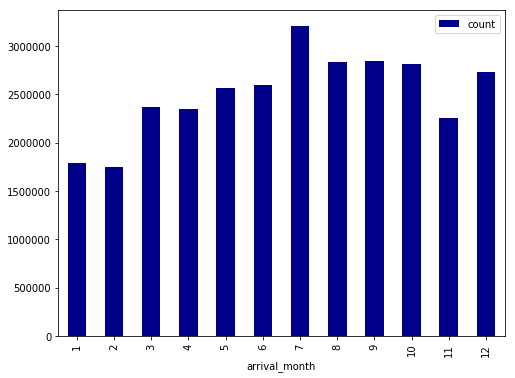

In [77]:
import matplotlib.pyplot as plt
month_count = df.groupBy('arrival_month').count().select('arrival_month', 'count').toPandas()
#month_count = month_count.set_index('arrival_month')
month_count = month_count.sort_values(by=['arrival_month'])
month_count.plot.bar(x='arrival_month', y='count', color='darkblue', figsize=(8, 6))

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

Although we have used Parquet for the analytical data in the project, the main target should be a scalable warehouse solution like `AWS Redshift`.

In a realistic scenario, the provided data will be updated on a regular basis in a data lake. In order to make the most recent data available for fast analytical querying (e.g. for administrative or policy needs), the ETL process needs to update the database on a regular basis, for example on a monthly, weekly, or daily basis. One tool to realise this is `Apache Airflow`.

As for the update intervals, we propose a nightly update. `Airflow` (or alternatively `AWS Step Functions`) can be configured such that the import data would be available early in the morning. Assuming that daily data will be available in the data lake around midnight, the ETL process can be automatically started in the middle of the night.

It has to be determined how long an incremental update takes on the given system (e.g. 2 or 3 hours), such that the start of this batch job can be set and the data can be available before office hours in the morning. In order to increase the data import throughput, an idea is to chunk the data to parallelize the input (and the number of nodes increased accordingly).

Access to a higher userbase (e.g. more than 100 analysts) would require to scale the database appropriately to handle all incoming OLAP-requests (all read-only operations). At some point, it may be advantageous to mirror the data into a read-optimized database such as `Apache Cassandra`.